In [1]:
from qiskit import Aer, execute
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qaoa import *
from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

### Let us import and draw the graph

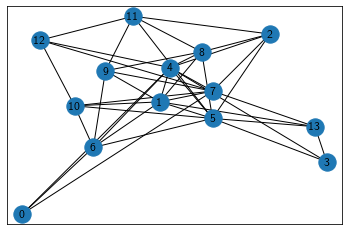

In [2]:
G = nx.read_gml("sample_graphs/w_ba_n14_k4_0.gml")
pos = nx.spring_layout(G)
nx.draw_networkx(G,apos=pos)

### Calculate the maximum value of the cost function

In [3]:
costs=listSortedCosts_MaxCut(G)
max_key = max(costs, key=costs.get)
max_val = costs[str(max_key)]
print(max_key,max_val)

01010011100010 17.158916153194056


### Draw the costs for all solutions

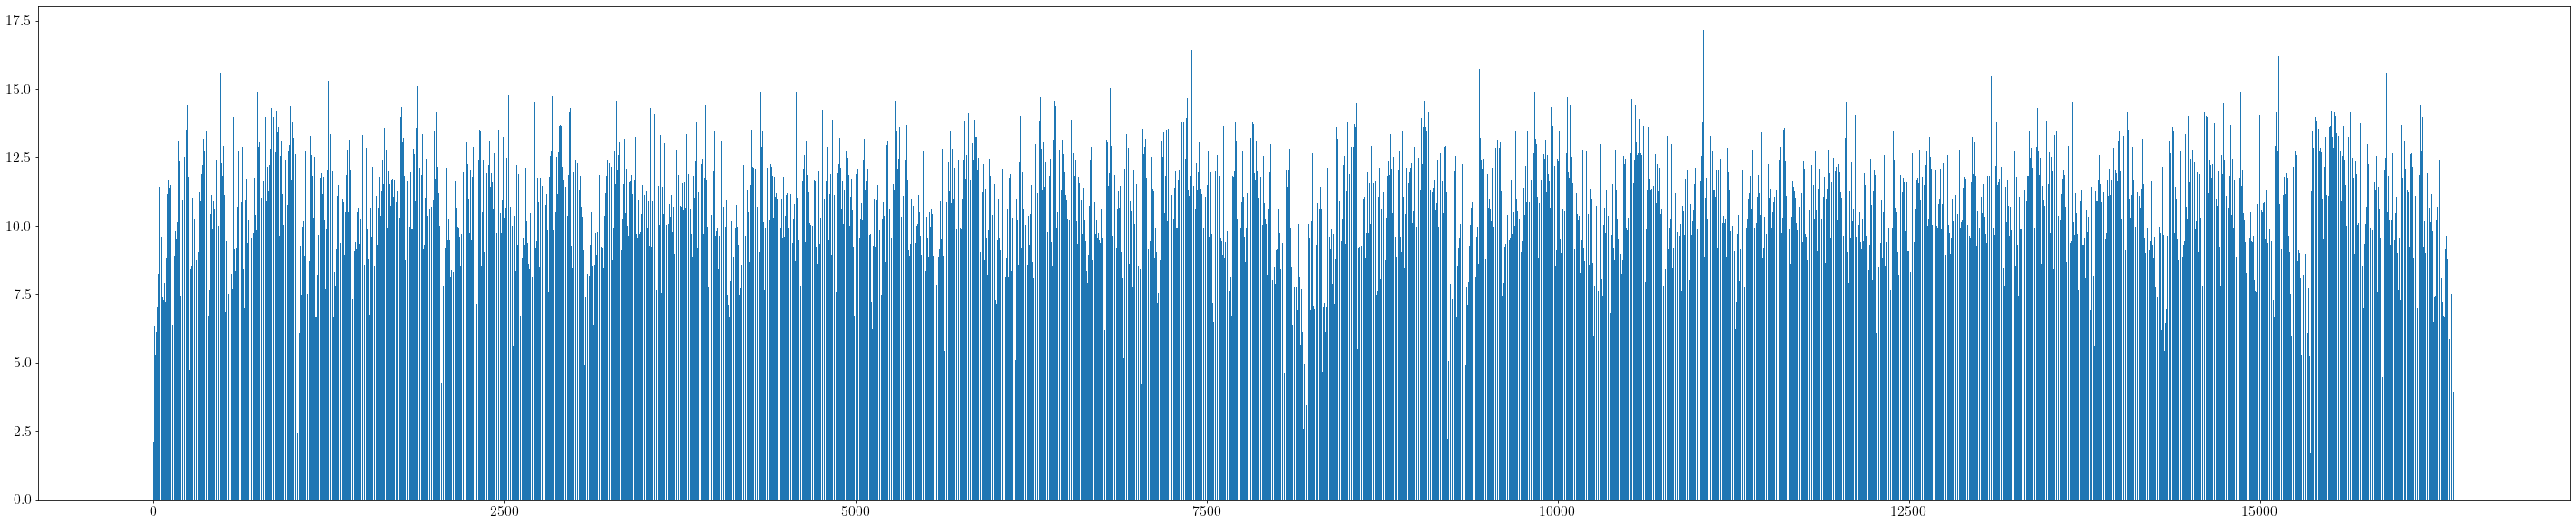

In [4]:
c=costshist_MaxCut(G)
pl.figure(figsize=(50,10))
a=pl.bar(np.arange(0,2**14),c)

### Draw the histogram of number of solutions for value of cost function

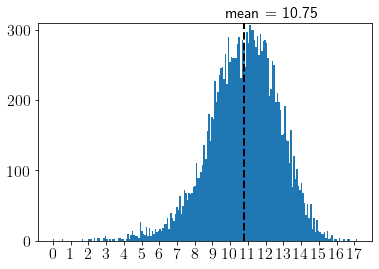

In [5]:
a=pl.hist(np.sort(c), bins=200)
pl.ylim(top=310)
min_ylim, max_ylim = pl.ylim()
max_ylim *=1.025
mean=np.mean(c)
pl.axvline(mean, color='k', linestyle='dashed', linewidth=2)
a=pl.text(mean-1, max_ylim, 'mean = {:.2f}'.format(mean))
a=pl.xticks(np.arange(0, max_val, step=1))

### Only 3.44% of all solutions have a cost of 14 or higher

In [6]:
good_solutions={}
for key in costs:
    if costs[key]>=14:
        good_solutions[key] = costs[key]
print(len(good_solutions),len(good_solutions)/2**14*100)

564 3.4423828125


### There are only 2 optimal solutions (0.01% of all solutions)

In [7]:
optimal_solutions={}
for key in costs:
    if costs[key]>=max_val:
        optimal_solutions[key] = 100
print(len(optimal_solutions),len(optimal_solutions)/2**14*100)

2 0.01220703125


### Calculate the energy landscape (this takes time)

In [8]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [9]:
version=1
circuits=[]
n=32
m=16
beta_max=2*np.pi
gamma_max=np.pi
for beta in np.linspace(0,beta_max,n):
    for gamma in np.linspace(0,gamma_max,m):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,version))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v1 = -np.array(expectationValue_MaxCut(job_sim.result(),G))

In [10]:
from scipy import optimize as opt

### Define function for the optimizer

In [11]:
def getval(x, backend, depth=1, version=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val=expectationValue_MaxCut(j.result(),G)
    global it, values, gamma, beta
    print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

### Run the optimizatoin using Nelder-Mead (derivative free method)

[0.5 1.3]
[0.525 1.3  ]
[0.5   1.365]
[0.475 1.365]
[0.45   1.3975]
[0.475 1.43 ]
[0.49375 1.3325 ]
[0.46875 1.3325 ]
[0.4921875 1.356875 ]
[0.5109375 1.324375 ]
[0.50195312 1.33453125]
[0.50039062 1.35890625]
[0.49541016 1.33910156]
[0.50517578 1.31675781]
[0.49543457 1.3468457 ]
[0.49868164 1.33681641]
[0.49707031 1.34570312]
[0.50356445 1.32564453]
[0.49869385 1.34068848]
[0.50031738 1.33567383]
[0.49951172 1.34011719]
Optimization terminated successfully.
         Current function value: -11.224323
         Iterations: 8
         Function evaluations: 21
Optimal value= [0.50195312 1.33453125]


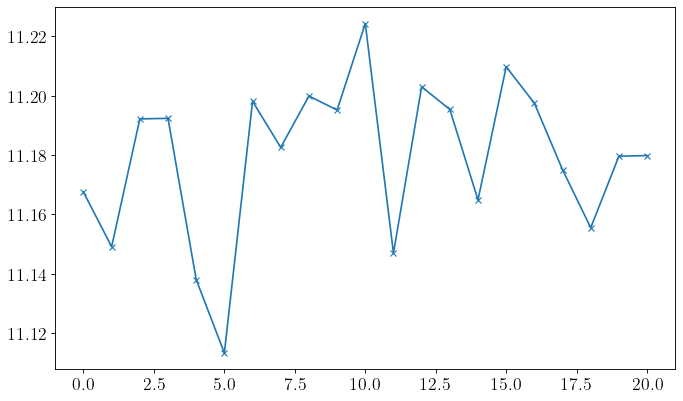

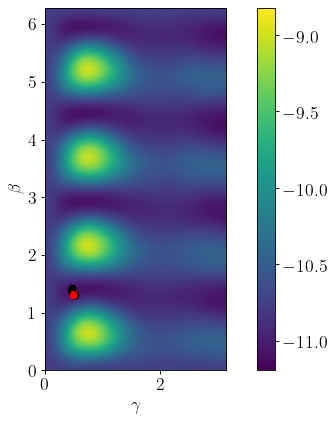

In [12]:
version=1
it=0
gamma={}
beta={}
values={}
xin=(.5,1.3)
out=opt.minimize(getval, x0=xin, method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-1, 'disp': True})
print("Optimal value=",out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,m),interpolation='bicubic',origin='lower',extent=[0,gamma_max,0,beta_max])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(xin[0],xin[1],'or')
pl.plot(out.x[0],out.x[1],'xr')

### Pick the best solution and its parameters along the optimization path

In [13]:
tmp = max(values, key=values.get)
x_best=(gamma[tmp], beta[tmp])
print(values[tmp], x_best)

[11.224323102946583] (0.501953125, 1.33453125)


### Calculate the average and maximum cost for the optimal parameters found with varying number of shots

In [14]:
num_shots=[]
bins_states={}
max_cost=[]
average_cost=[]
for i in range(4,14):
    ns=2**i
    num_shots.append(ns)
    jv1 = execute(createCircuit_MaxCut(x_best,G,1,version), backend_sim, shots=ns)
    bins_states[ns], mc, ac = bins_comp_basis(jv1.result().get_counts(),G)
    max_cost.append(mc)
    average_cost.append(ac)

### Calculate the average and maximum cost for random solutions with varying number of shots

In [15]:
import random
bins_states_rand={}
max_cost_rand=[]
average_cost_rand=[]
for i in range(4,14):
    ns=2**i
    tmp_states={}
#     tmp_max=0
#     tmp_av=0
    for j in range(0,ns):
        s = random.randint(0, ns - 1)
        binstring="{0:b}".format(s).zfill(14)
        y=[int(i) for i in binstring]
        c=cost_MaxCut(y,G)
        tmp_states[binstring]=c
#         tmp_max=max(c,tmp_max)
#         tmp_av+=c
    bins_states_rand[ns], mc, ac = bins_comp_basis(tmp_states,G)
    max_cost_rand.append(mc)
    average_cost_rand.append(ac)

### Plot comparison of random solution and QAOA

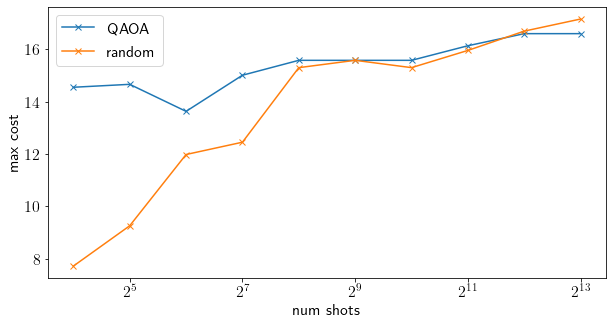

In [16]:
pl.figure(figsize=(10,5))
pl.semilogx(num_shots, max_cost,'x-', basex=2, label='QAOA')
pl.semilogx(num_shots, max_cost_rand,'x-', basex=2, label='random')
pl.legend()
pl.ylabel('max cost')
tmp=pl.xlabel('num shots')

Small comment on the result above: This shows that QAOA produces "good" results with a very high likelihood. Randomly choosing 2^13 solutions should give a good result as well, given, that there are only 2^14 solutions in total

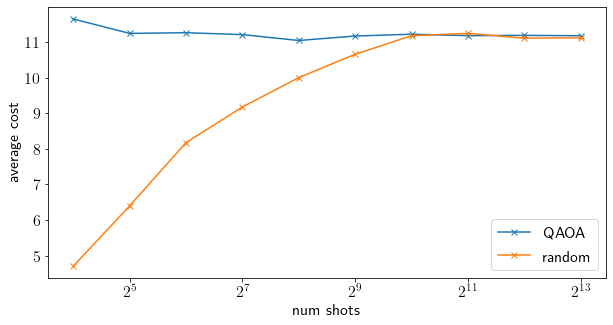

In [17]:
pl.figure(figsize=(10,5))
pl.semilogx(num_shots, average_cost,'x-', basex=2, label='QAOA')
pl.semilogx(num_shots, average_cost_rand,'x-', basex=2, label='random')
pl.legend()
pl.ylabel('average cost')
tmp=pl.xlabel('num shots')